# Basic Classifier using InferDotNet

## Introduction

This notebook looks at building a `1-feature` probabilistic classifier - a.k.a. a Bayes point machine. Whilst reading the <a href='https://mbmlbook.com/EmailClassifier_A_model_for_classification.html'>Model Based Machine Learning</a> ebook by <a href="https://www.microsoft.com/en-us/research/people/jwinn/?from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fpeople%2Fjwinn%2F">John Winn</a> et al. from <a href="https://www.microsoft.com/en-us/research/">Microsoft Reseach</a> I found it very confusing diving right into the model based machine learning approach and was looking for a way to tie MBML with traditional ML - this notebook is the result.

Although the <a href="https://mbmlbook.com/index.html">MBML book</a> is a brilliant book, the first 3 chapters cover very probabilistic approaches to solving problem - as it should, as that is what the book is all about 😅.

However, coming from traditional machine learning I was glad to see that in Chapter 4 they build a binary classifier, albeit in a probabilistic fashion. The MBML book uses <a href="https://en.wikipedia.org/wiki/Factor_graph#:~:text=A%20factor%20graph%20is%20a,the%20factorization%20of%20a%20function.&text=Factor%20graphs%20generalize%20constraint%20graphs,where%20all%20factors%20are%20constraints.">factor graphs</a> across the board - if you're not yet aquited with factor graphs, the TLDR from  <a href="https://en.wikipedia.org/wiki/Factor_graph#:~:text=A%20factor%20graph%20is%20a,the%20factorization%20of%20a%20function.&text=Factor%20graphs%20generalize%20constraint%20graphs,where%20all%20factors%20are%20constraints.">wikipedia</a>:

> A factor graph is a bipartite graph representing the factorization of a function. Given a factorization of a function $g$,
> $$g(X_1,X_2,\dots,X_n) = \prod_{j=1}^m f_j(S_j),$$
> where ${\displaystyle S_{j}\subseteq \{X_{1},X_{2},\dots ,X_{n}\}}$, the corresponding factor graph ${\displaystyle G=(X,F,E)}$ consists of variable vertices ${\displaystyle X=\{X_{1},X_{2},\dots ,X_{n}\}}$, factor vertices ${\displaystyle F=\{f_{1},f_{2},\dots ,f_{m}\}}$, and edges ${\displaystyle E}$. The edges depend on the factorization as follows: there is an undirected edge between factor vertex ${\displaystyle f_{j}}$ and variable vertex ${\displaystyle X_{k}}$  iff ${\displaystyle X_{k}\in S_{j}}$.

In other words, factor graphs are a way to factorize functions, and factor graphs as used in MBML specifically where $g(X_1,X_2,\dots,X_n)$ is a joint distribution or a joint likelihood function, and the factorization depends on the conditional independencies among the variables. These factor graphs can be solved using various algorithms like Belief propagation, also known as sum-product message passing, and a go-to platform to perform these calculations is C#'s dotnet using the Microsoft funded inferDotNet package. 

### The Setup

This notebook duplicates the concepts in chapter 4 of MBML, which is titled: `Uncluttering Your Inbox` and is all about building a classifier that can classify whether a person is going to reply to an email or not, and then using this classifier to, well, uncluttering your inbox. The chapter starts off by building a naive 1 feature classifier with the following factor graph:


<p align="center">
    <img src='assets/email-classifier.jpg' width='300px'>
</p>

The factor graph translates into the following. We've got some `featureValue` that we observe (that's why it is grayed out - it's "observed") which is our feature value, i.e. $X_1$. Then we create a random variable called score, calculated as $score = featureValue \times weight$, i.e. $y=w\times x_1$. After that it gets a bit funky. We are trying to build a classifier, in other words, we want to "learn" some mapping, $f(X)$, that will produce a value (score) when we pass our feature value(s) $x_1$ through. We whould then like to determine a threshold for that score to say whether our feature value(s) comes from one class or the other. The most basic classifier to do this job is Logistic Regression. Here we assume a mapping from $x$ to $y$ as

$${\displaystyle y={\begin{cases}1&\beta _{0}+\beta _{1}x+\varepsilon >0\\0&{\text{else}}\end{cases}}}$$

where $\beta_0$ and $\beta_1$ are parameters that we will estimate in our training process and $\epsilon$ is the standard error term. This is basically what this factor graph is trying to do, build a similiar classifier, although in a very different approach - the Model Based Machine Learning approach. From the <a href="https://mbmlbook.com/EmailClassifier_A_model_for_classification.html">MBML book</a>:


> You may be surprised to learn that many classification algorithms can be interpreted as doing approximate inference in some probabilistic model. So rather than running a classification algorithm, we can instead build the corresponding model and use an inference algorithm to do classification. Why would we do this instead of using the classification algorithm? Because a model-based approach to classification gives us several benefits:
> * The assumptions in the classifier are made explicit. This helps us to understand what the classifier is doing, which can allow us to improve how we use it to achieve better prediction accuracy.
> * We can modify the model to improve its accuracy or give it new capabilities, beyond those of the original classifier.
> * We can use standard inference algorithms both to train the model and to make predictions with it. This is particularly useful when modifying the model, since the training and prediction algorithms remain in sync with the modified model.


They MBML book does come with code snippets, however most of the time it is very objectified code, which doesn't really help to learn the basics of inferDotNet, you can see <a href='https://github.com/dotnet/mbmlbook/blob/master/src/4.%20Uncluttering%20Your%20Inbox/Models/OneFeatureModel.cs'>here</a>.

So instead of using their code, this repo looks at creating the above factor graph, but instead of classifying whether an email is replied to or not, we dumb it down even further and aim to classify flowers from the Iris dataset as Setosa or Virginica using their sepal length attribute. If you haven't used the Iris dataset before, it consists of 150 flower oberservations for three different Iris species: Setosa, Versicolor and Virginica with their associated attributes: sepal length, sepal width, petal length and petalwidth. Here we are only using the Setosa and Verginica species and their sepal length attribute that is disibtrubed as 

<p align="center">
    <img src='assets/sepal-length-dist.jpg' width='70%'>
</p>

So our factor graph looks like this:

<p align="center">
    <img src='assets/iris-classifier.jpg' width='300px'>
</p>

So what is happening here? Model based machine learning is all about *assumptions*. The assumptions chapter 4 makes to create this factor graph is:

1. The feature values can always be calculated, for any email.
2. Each email has an associated continuous score which is higher when there is a higher probability of the user replying to the email.
3. If an email’s feature value changes by $x$, then its score will change by $weight \times x$ for some fixed, continuous weight.

In our flower case:

1. The feature values can always be calculated, for any flower.
2. Each flower has an associated continuous score which is higher when there is a higher probability of the flower being Setosa.
3. If an flower's feature value changes by $x$, then its score will change by $weight \times x$ for some fixed, continuous weight.

Assumption 1 and 2 is just house keeping, but assumption 3 gives rise to:

<p align="center">
    <img src='assets/assumption-3.jpg' width='300px'>
</p>

From MBML:
> In drawing the factor graph, we’ve had to assume some prior distribution for weight. In this case, we have assumed that the weight is drawn from a Gaussian distribution with zero mean, so that it is equally likely to be positive or negative.

Assumption 4 becomes: The weight for a feature is equally likely to be positive or negative.

We might be tempted to do the following:

<p align="center">
    <img src='assets/threshold.jpg' width='300px'>
</p>

Just add a threshold with a lot of variance centered around 0 and let the model go. However, MBML warns against this as any inference algorithm will fail trying to compute this model. The book gives the reason

> Unfortunately, if we attempt to run inference on this model then any inference algorithm we try will fail. This is because some of the observed values have zero probability under the model. In other words, there is no way that the data-generating process encoded by our model could have generated the observed data values. When your data has zero probability under your model, it is a sure sign that the model is wrong!

What this means, is there are some outliers appear to come from one side of the classification, but are really from the other class. Looking at our sepal length distribution below, we highlight which data points will have zero probability under the model.

<p align="center">
    <img src='assets/sepal-length-dist-with-overlap.jpg' width='500px'>
</p>

As is common in MBML, to combat this, we add some noise to our observation's score calculation. In other words, we take the score that is generated by taking the product of the sepal length ($x$) and the weight ($w$) and we add some Gaussian noise by fixing the mean of a Gaussian random variable to the calculated score ($x \times w$) with variance 10.

So we get the following factor graph with added noise and we threshold the noisyScore using a random Gaussian variable with prior $\mathcal{N}(0,10)$.

<p align="center">
    <img src='assets/iris-classifier.jpg' width='300px'>
</p>

Coming to grips with factors graphs, their associated assumptions and how to navigate pitfalls like observed data having zero probability under a model is one part of the MBML journey. The next is converting the factor graph into working C# code using the inferDotNet package.


### The C# Model Code

The first piece of C# code in Program.cs is pure C# (no inferDotNet) and just reads in the CSV generated by this notebook:

```C#
string dataDir = args[0];
string datasetFilename = dataDir+args[1];
string[] lines = File.ReadAllLines(datasetFilename);
bool[] isSetosaLabel = new bool[lines.Length];
double[] featureVal = new double[lines.Length];

for (int i = 0; i < lines.Length; i++)
{
    string[] strArray = lines[i].Split('|');
    isSetosaLabel[i] = strArray[1] == "1";
    featureVal[i] = float.Parse(strArray[0].Replace(".", ","));
}
```

Next we create the model. 

We start by creating a `Range` variable from the `Microsoft.ML.Probabilistic.Models.Range` namespace that we alias as `Range`. We will use this range to iterate over all of our observations/flowers.

```C#
int numberOfFlowers = lines.Length;
Range flower = new Range(numberOfFlowers).Named("flower");
```

The next bit of inferDotNet code is to enure our range gets handled sequentially. This is a bit of an artifact from bringing across code from the email example as for email temporal consistency is preferred. For flowers' sepal lengths, maybe less so, but it can't hurt.

```C#
flower.AddAttribute(new Sequential());
```

Next we declare the variables in our factor graph within InferDotNet, i.e. all the rounded squares. We can use our `flower Range` along with `Variable.Array<T>` to create the variables for our feature $x$ and our label $y$.

```C#
// The feature - x
VariableArray<double> featureValues = Variable.Array<double>(flower).Named("featureValue").Attrib(new DoNotInfer());
// The label - y
VariableArray<bool> isSetosa = Variable.Array<bool>(flower).Named("isSetosa");
```

For our random variables, weight and threshold, we initialise them using `Variable.GaussianFromMeanAndVariance`.

```C#
// The weight - w
Variable<double> weight = Variable.GaussianFromMeanAndVariance(0,1).Named("weight");     
// The threshold
Variable<double> threshold = Variable.GaussianFromMeanAndVariance(-5,10).Named("threshold");
```

Next we can loop over our `flower Range` using `Variable.ForEach` and calculate the score, and consequently our noisyScore. We can then make our "prediction" by checking whether the noisy score is above or below our threshold. Something to note here is that the `Variable.ForEach` method takes a range as argument, and within the `using` block, that same variable, i.e. `flower`, is the iterating variable - this was a bit confusing to me and took some getting use to. So no counter variable `i` for a loop like `for(i=0, ...)`, instead just `using (Variable.ForEach(flower)){}` and you can use the `flower` variable inside the block.

```C#
using (Variable.ForEach(flower))
{
    var score = (featureValues[flower] * weight).Named("score");

    var noisyScore = Variable.GaussianFromMeanAndVariance(score, 10).Named("noisyScore");
    isSetosa[flower] = noisyScore > threshold;
}
```

We've got two more steps to go before we've converted our factor graph into some code, setting our observed values and running inference. To observe values within InferDotNet we do the following:

```C#
isSetosa.ObservedValue = isSetosaLabel;
featureValues.ObservedValue = featureVal;
```

Something to note here is that `isSetosa` and `featureValues` are our inferDotNet variables, whereas `isSetosaLabel` and `featureVal` are our vanilla C# arrays.

The final bit in the puzzle is to run inference, i.e. let the energy flow our model and let the priors get updated with evidence - if there is any evidence. For this example we'll be using the `ExpectationPropagation` (EP) algorithm to do our message passing. Another option is to use `VariationalMessagePassing` (VMP), however this doesn't work for our current setup and my knowledge on these algorithms is still a bit vague at this stage to know why.

```C#
var InferenceEngine = new InferenceEngine(new ExpectationPropagation());
InferenceEngine.NumberOfIterations = 50;
```

We can then infer our posterior weight and threshold Gaussians by running:

```C#
Gaussian postWeight = InferenceEngine.Infer<Gaussian>(weight);
Gaussian postThreshold = InferenceEngine.Infer<Gaussian>(threshold);
```

To be able to get the results back into this notebook I use the following to create a CSV with the means and variances of our posterior Gaussians.

```C#
var results = new StringBuilder();

results.AppendLine("variable;mean;variance");
var line = string.Format("postWeight;{0};{1}", postWeight.GetMean(), postWeight.GetVariance());
results.AppendLine(line.Replace(',', '.'));
line = string.Format("postThreshold;{0};{1}", postThreshold.GetMean(), postThreshold.GetVariance());
results.AppendLine(line.Replace(',', '.'));

File.WriteAllText(dataDir+"results.csv", results.ToString());
```

## Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy import special
import numpy as np

In [4]:
# Gaussian CDF
def cdf(x,mu,sig):
    return 0.5*(1+special.erf((x-mu)/(sig*np.sqrt(2))))

### Config

In [5]:
data_dir = Path('../data')
input_dataset = data_dir/'iris.csv'
output_dataset = data_dir/'iris-one-feature.csv'
model_output = data_dir/'model-output.csv'

### Data Acquisition

In [6]:
df = pd.read_csv(input_dataset)

# We subset the data to only have Setosa and Virginica
df_2_class = df[df['class'].\
    isin(['Iris-virginica', 'Iris-setosa'])].copy()

In [7]:
df_2_class.sample(2)

,sepallength,sepalwidth,petallength,petalwidth,class
4,5.0,3.6,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


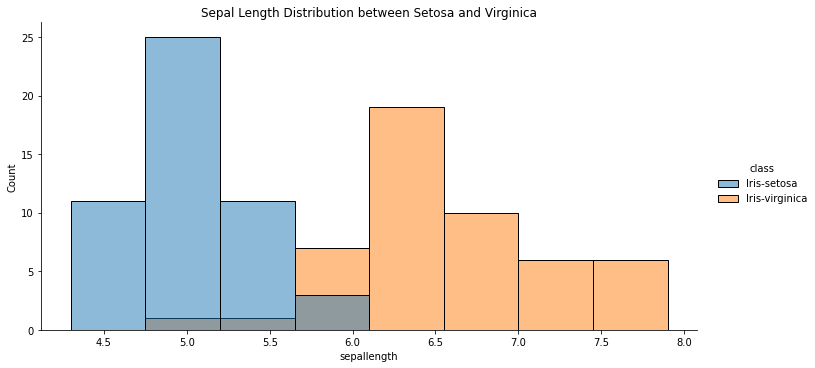

In [8]:
f = sns.displot(data=df_2_class,
                x='sepallength',
                aspect=2,
                hue='class')
plt.title('Sepal Length Distribution between Setosa and Virginica');

In [9]:
df_2_class.loc[df_2_class['class'] == 'Iris-setosa', 'is_setosa'] = 1
df_2_class.loc[df_2_class['class'] == 'Iris-virginica', 'is_setosa'] =  0

In [10]:
# When scaling this go a bit weird - still need to figure out why
from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()
df_2_class.sepallength = scaler.fit_transform(df_2_class.sepallength.values.reshape(-1,1)).flatten()

In [11]:
df_2_class[['sepallength', 'is_setosa']].\
to_csv(output_dataset,
       header=False,
       sep='|',
       index=False)

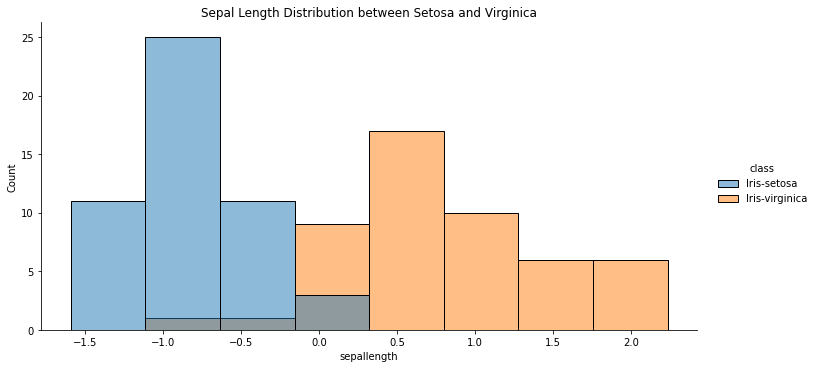

In [12]:
f = sns.displot(data=df_2_class,
                x='sepallength',
                aspect=2,
                hue='class')
plt.title('Sepal Length Distribution between Setosa and Virginica');

In [13]:
df_2_class.sepallength.describe()

count    1.000000e+02
mean     3.223810e-16
std      1.005038e+00
min     -1.591571e+00
25%     -8.473494e-01
50%     -1.031278e-01
75%      7.474111e-01
max      2.235854e+00
Name: sepallength, dtype: float64

## Run Model

In [22]:
ls ../data

iris.csv  iris-one-feature.csv  results.csv


In [25]:
cmd = f'dotnet run --project ../models/bayes-point-classifier/ ../data/ iris-one-feature.csv'

In [26]:
!{cmd}

===Arguments:
../data/
iris-one-feature.csv
Reading in data from ../data/iris-one-feature.csv
Looping through lines
Line 0
strArray length: 2
strArray[0]: -0,7410320187139096
strArray[1]: 1,0
Line 1
strArray length: 2
strArray[0]: -0,953666744313309
strArray[1]: 1,0
Line 2
strArray length: 2
strArray[0]: -1,1663014699127092
strArray[1]: 1,0
Line 3
strArray length: 2
strArray[0]: -1,27261883271241
strArray[1]: 1,0
Line 4
strArray length: 2
strArray[0]: -0,8473493815136093
strArray[1]: 1,0
Line 5
strArray length: 2
strArray[0]: -0,4220799303148086
strArray[1]: 1,0
Line 6
strArray length: 2
strArray[0]: -1,27261883271241
strArray[1]: 1,0
Line 7
strArray length: 2
strArray[0]: -0,8473493815136093
strArray[1]: 1,0
Line 8
strArray length: 2
strArray[0]: -1,4852535583118094
strArray[1]: 1,0
Line 9
strArray length: 2
strArray[0]: -0,953666744313309
strArray[1]: 1,0
Line 10
strArray length: 2
strArray[0]: -0,4220799303148086
strArray[1]: 1,0
Line 11
strArray length: 2
strArray[0]: -1,0599841

## Analyze Results

In [27]:
df_results = pd.read_csv(data_dir/'results.csv', sep=';')
df_results

,variable,mean,variance
0,postWeight,-4.303792,0.673502
1,postThreshold,0.059541,1.550078


In [28]:
postWeightMean = df_results[df_results.variable == "postWeight"]['mean'].values[0]
postWeightVariance = df_results[df_results.variable == "postWeight"]['variance'].values[0]
postThresholdMean = df_results[df_results.variable == "postThreshold"]['mean'].values[0]
postThresholdVariance = df_results[df_results.variable == "postThreshold"]['variance'].values[0]
postThresholdStandardDev = np.sqrt(postThresholdVariance)
postWeightMean, postWeightVariance, postThresholdMean, postThresholdVariance, postThresholdStandardDev

(-4.303792036484977,
 0.6735017530376319,
 0.0595410792296036,
 1.5500782345729691,
 1.2450213791630123)

In [29]:
sampledWeight = np.random.normal(postWeightMean, np.sqrt(postWeightVariance))
sampledWeight, postWeightMean

(-2.8729110197706773, -4.303792036484977)

In [30]:
df_2_class['score'] = df_2_class.sepallength * postWeightMean

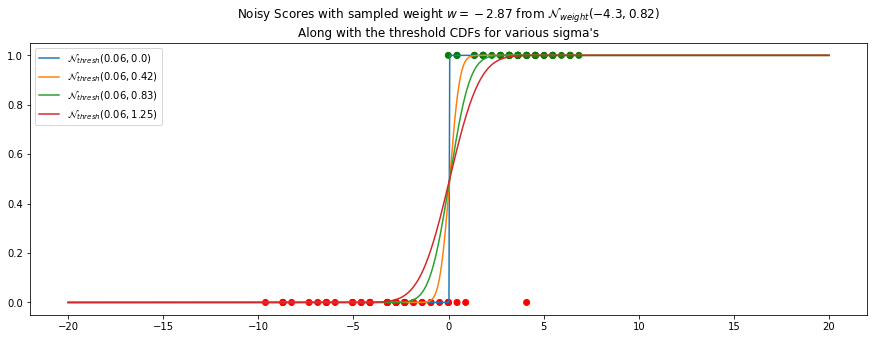

In [31]:
x_min_max = 20
x = np.linspace(-1*x_min_max, x_min_max, 1000)
fig = plt.figure(figsize=(15,5))

for sigma in [postThresholdStandardDev* v for v in np.linspace(0.0001, 1, 4)]:
    sig = str(round(sigma, 2))
    mean = str(round(postThresholdMean, 2))
    label = "${\\mathcal {N}_{thresh}}("+mean+","+sig+")$"
    y = cdf(x, postThresholdMean, sigma)
    plt.plot(x, y, label=label)

sig = str(round(np.sqrt(postWeightVariance), 2))
mean = str(round(postWeightMean, 2))
plt.scatter(x=df_2_class.score,
            y=df_2_class.is_setosa,
            c=df_2_class.is_setosa.map({0:'red', 
                                        1:'green'}))
plt.legend()
plt.title("Noisy Scores with sampled weight $w="+str(round(sampledWeight,2))+"$"+""" from ${\\mathcal {N}_{weight}}("""+mean+","+sig+")$"+"""
Along with the threshold CDFs for various sigma's""");